## Visualize trained models

This notebook helps visualize the training progress as well as the resulting model

#### imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import IPython
from IPython.display import display, HTML

from State_Generator import Generator
from Model import Complex_CA
from matplotlib.colors import ListedColormap
import time

In [ ]:
#torch.set_printoptions(precision=2)
#torch.set_printoptions(threshold=10000)
#torch.set_printoptions(sci_mode=False)

#### Load model and data

In [8]:
batch_size = 16
#device = torch.device('mps:0' if torch.backends.mps.is_available else 'cpu')
device = torch.device('cpu')
model = Complex_CA(device, batch_size)

#model.load_state_dict(torch.load('models/complex_ca_moving_best1.pth'))
#model.load_state_dict(torch.load('models/complex_ca_moving2_temp10.pth'))
#model.load_state_dict(torch.load('models/complex_ca_moving_softmax_temp2.pth')) #using softmax

#model.load_state_dict(torch.load('models/ca_live_temp6.pth'))
#model.load_state_dict(torch.load('models/ca_live1_temp99.pth', map_location=device)) #with count of living cells above 0.8

#model.load_state_dict(torch.load('models/ca_live1_temp77.pth', map_location=device)) #with count of living cells above 0.1
#model.load_state_dict(torch.load('models/ca_live1_random_temp51.pth', map_location=device)) #with count of living cells above 0.1

#bigger in size - another model type
#model.load_state_dict(torch.load('models/ca_live2_temp15.pth'))


#model.load_state_dict(torch.load('models/ca_sigmoid_temp84.pth', map_location=device))

#model.load_state_dict(torch.load('models/complex_ca_moving_temp49.pth'))
#model.load_state_dict(torch.load('models/complex_ca_moving1_temp11.pth'))
#model.load_state_dict(torch.load('models/complex_ca_moving1_temp99.pth', map_location=device)) #able in moving - no output functions
#model.load_state_dict(torch.load('models/complex_ca_moving2_temp97.pth', map_location=device)) #forced harder boundaries - never moves


#Actual mlp: new model structure
#model.load_state_dict(torch.load('models/ca_mlp26.pth'))
#model.load_state_dict(torch.load('models/ca_mlp36.pth'))
#model.load_state_dict(torch.load('models/ca_mlp43.pth'))
model.load_state_dict(torch.load('models/ca_mlp99_1.pth', map_location=device))

#golden models!
#model.load_state_dict(torch.load('models/moving_ca1.pth', map_location=device))

model = model.to(device)
#losses = np.load('losses_none.npy')
#losses = np.load('losses_live2.npy')
losses = np.load('losses_mlp.npy')
random_state = False
generator = Generator(device, random_state)

#### Visualize loss during training

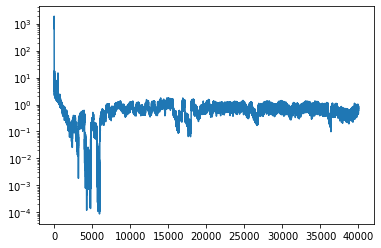

In [9]:
#fig, axes = plt.subplots()
plt.plot(losses)
plt.yscale('log')
plt.show()


#### Visualize spreading of scent

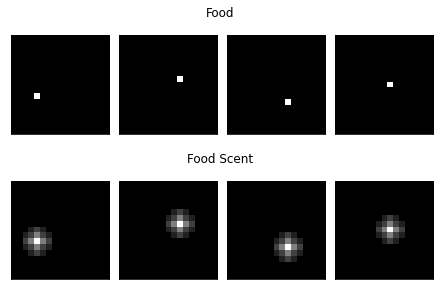

In [110]:
food = torch.tensor(generator.get_random_food(16), device=device)
scent = model.perceive_scent(food)

fig, axs = plt.subplots(nrows=2, ncols=1, constrained_layout=True) #create 2 rows

for ax in axs:
    ax.remove() #cleaning

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for row, subfig in enumerate(subfigs):
    if row == 0:
        title = 'Food'
    else: 
        title = 'Food Scent'
    subfig.suptitle(title)

    axs = subfig.subplots(nrows=1, ncols=4) #create columns in row
    for col, ax in enumerate(axs):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if row == 0:
            ax.matshow(food[col].detach().cpu().numpy(), cmap='gray')
        else:
            ax.matshow(scent[col].detach().cpu().numpy(), cmap='gray')

#### Visualize perceived neighborhood

#### Visualize CA - Animate

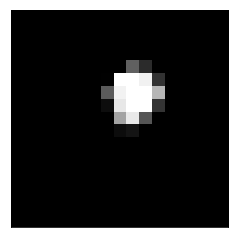

In [60]:
#state = generator.generate_stationary_state(batch_size)
state = generator.generate_moving_state(1, batch_size)

def extract_data(cell):
    return cell.detach().cpu().numpy()[0,0]

@torch.no_grad()
def animate(i):
    global cell
    global food
    cell, food, _, _ = model(cell, food, 1)
    mat.set_data(extract_data(cell)) 

cell = torch.tensor(state.x, device=device)
food = torch.tensor(state.food, device=device)

fig, ax = plt.subplots()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
mat = ax.matshow(extract_data(cell), cmap='gray')

IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=150, interval=50).to_jshtml())

#### Save video

In [14]:
def save_video_temp(video_data):
    name = 'videos/temp.html'
    with open(name, 'w') as f:
        f.write(video_data)

def save_video():
    ts = time.time().__round__()

    temp = 'videos/temp.html'
    name = 'videos/ca_' + str(ts) + '.html'
    with open(temp, 'r') as t:
        with open(name, 'w') as f:
            f.write(t.read())

#### Combined simulation and CA movement

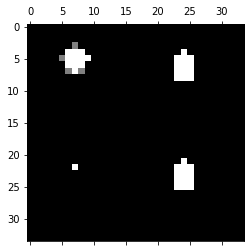

In [15]:
#state = generator.generate_stationary_state(batch_size)
state = generator.generate_moving_state(50, batch_size)

def extract_data(cell, target):
    row1 = np.hstack((cell[0, 0].detach().cpu().numpy(), target[0]))
    row2 = np.hstack((state.food[0], state.y[0]))
    return np.vstack((row1, row2))

@torch.no_grad()
def animate(i):
    global cell
    global target
    global food
    global food_coord
    cell, food, live_count, _ = model(cell, food, 1)
    #print((cell > 1.1).to(torch.float).sum()) # this shows the potential importance of including clamp
    #print('live_count: ', live_count[0].item())
    if i % 2 == 0:
        target = generator.move_towards_food(target, food_coord)
        #print(target.sum(dim=(1,2)))
    mat.set_data(extract_data(cell, target)) 

cell = torch.tensor(state.x, device=device)
food = torch.tensor(state.food, device=device)
target = state.x[:, 0]
food_coord = generator.get_food_coord_from_food(state.food)
fig, ax = plt.subplots()

cmap = ListedColormap(['k', 'gray', 'w'])
mat = ax.matshow(extract_data(cell, target), cmap=cmap)
#mat = ax.matshow(extract_data(cell, target), cmap='gray')

video = IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=150, interval=50).to_jshtml())
save_video_temp(video.data)
video

In [13]:
#save
save_video()

### Display some of the videos

In [ ]:
def open_video(name):
    with open(name, 'r') as f:
        return IPython.display.HTML(f.read())

In [ ]:
video1 = open_video('videos/ca_1668948461.html')
video1

In [ ]:
video2 = open_video('videos/ca_1668949208.html')
video2

In [ ]:
#video3 = open_video('videos/ca_1668951258.html')
video3 = open_video('videos/ca_1668951183.html')
video3

In [ ]:
video4 = open_video('videos/ca_1668949242.html')
video4

In [ ]:
#video5 = open_video('videos/ca_1668951971.html')
#video5 = open_video('videos/ca_1668952013.html')
video5 = open_video('videos/ca_1668952169.html')
video5

In [ ]:
video6 = open_video('videos/ca_1668952346.html')
video6

In [ ]:
video7 = open_video('videos/ca_1669193875.html')
video7

In [ ]:
video8 = open_video('videos/ca_1669208770.html')
video8

In [ ]:
video9 = open_video('videos/ca_1669209073.html')
video9

#### Using random inputs

In [ ]:
#Random states - on live1
video10 = open_video('videos/ca_1669302671.html')
video10

#### Using linear layers instead of convolution with 1d kernel

In [ ]:
video11 = open_video('videos/ca_1669571145.html')
video11

In [ ]:
video12 = open_video('videos/ca_1669571447.html')
video12

In [ ]:
video13 = open_video('videos/ca_1669572244.html')
video13

In [ ]:
video14 = open_video('videos/ca_1669581656.html')
video14

In [ ]:
video15 = open_video('videos/ca_1669585239.html')
video15